Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Exploring RDF with openCypher - GeoNames & Air Routes

The [Resource Description Framework (RDF)](https://en.wikipedia.org/wiki/Resource_Description_Framework) is a framework for representing information about resources in a graph form. Unlike traditional databases that store data in tables, RDF structures data as statements of fact called ‘triples,’ consisting of a subject, predicate, and object. This simple yet powerful model allows for the creation of intricate networks of data.

There are numerous publicly available RDF datasets covering a wide range of fields, including geography, life sciences, cultural heritage, and government data. 

These datasets, along with the considerable amount of RDF embedded within web pages, are collectively known as the [Semantic Web](https://en.wikipedia.org/wiki/Semantic_Web) of [Linked Data](https://en.wikipedia.org/wiki/Linked_data).

[SPARQL](https://en.wikipedia.org/wiki/SPARQL) is the standard query language for RDF. While powerful, it lacks some useful features, such as path finding.

[openCypher](https://opencypher.org/) is a popular graph query language that enables intuitive and expressive querying, including path finding and pattern matching. 

[Neptune Analytics](https://docs.aws.amazon.com/neptune-analytics/latest/userguide/what-is-neptune-analytics.html) can run openCypher queries and graph algorithms over RDF data. 

In this notebook, we explore a linked RDF graph model comprised of two data sources:
1. Air Routes - An RDF model that describes airports, airlines, and flight paths around the world. The data originates from the [OpenFlights Airports Database](https://openflights.org/data.php).
2. GeoNames cities and countries - A small subset of [GeoNames](https://www.geonames.org/), the massive public RDF geographical database.

### The Air Routes-GeoNames Ontology (Schema)

The ontologies and datasets used in this notebook are available as NTRIPLES files in S3:
- Air Routes: [s3://aws-neptune-customer-samples/airroutes-rdf/airroutes.nt](s3://aws-neptune-customer-samples/airroutes-rdf/airroutes.nt)
- GeoNames: [s3://aws-neptune-customer-samples/geonames-rdf/geonames-cities-countries.nt](s3://aws-neptune-customer-samples/geonames-rdf/geonames-cities-countries.nt)

In this notebook, we work around a subset of the GeoNames and AirRoutes ontologies, linked by the country code, as shown here:

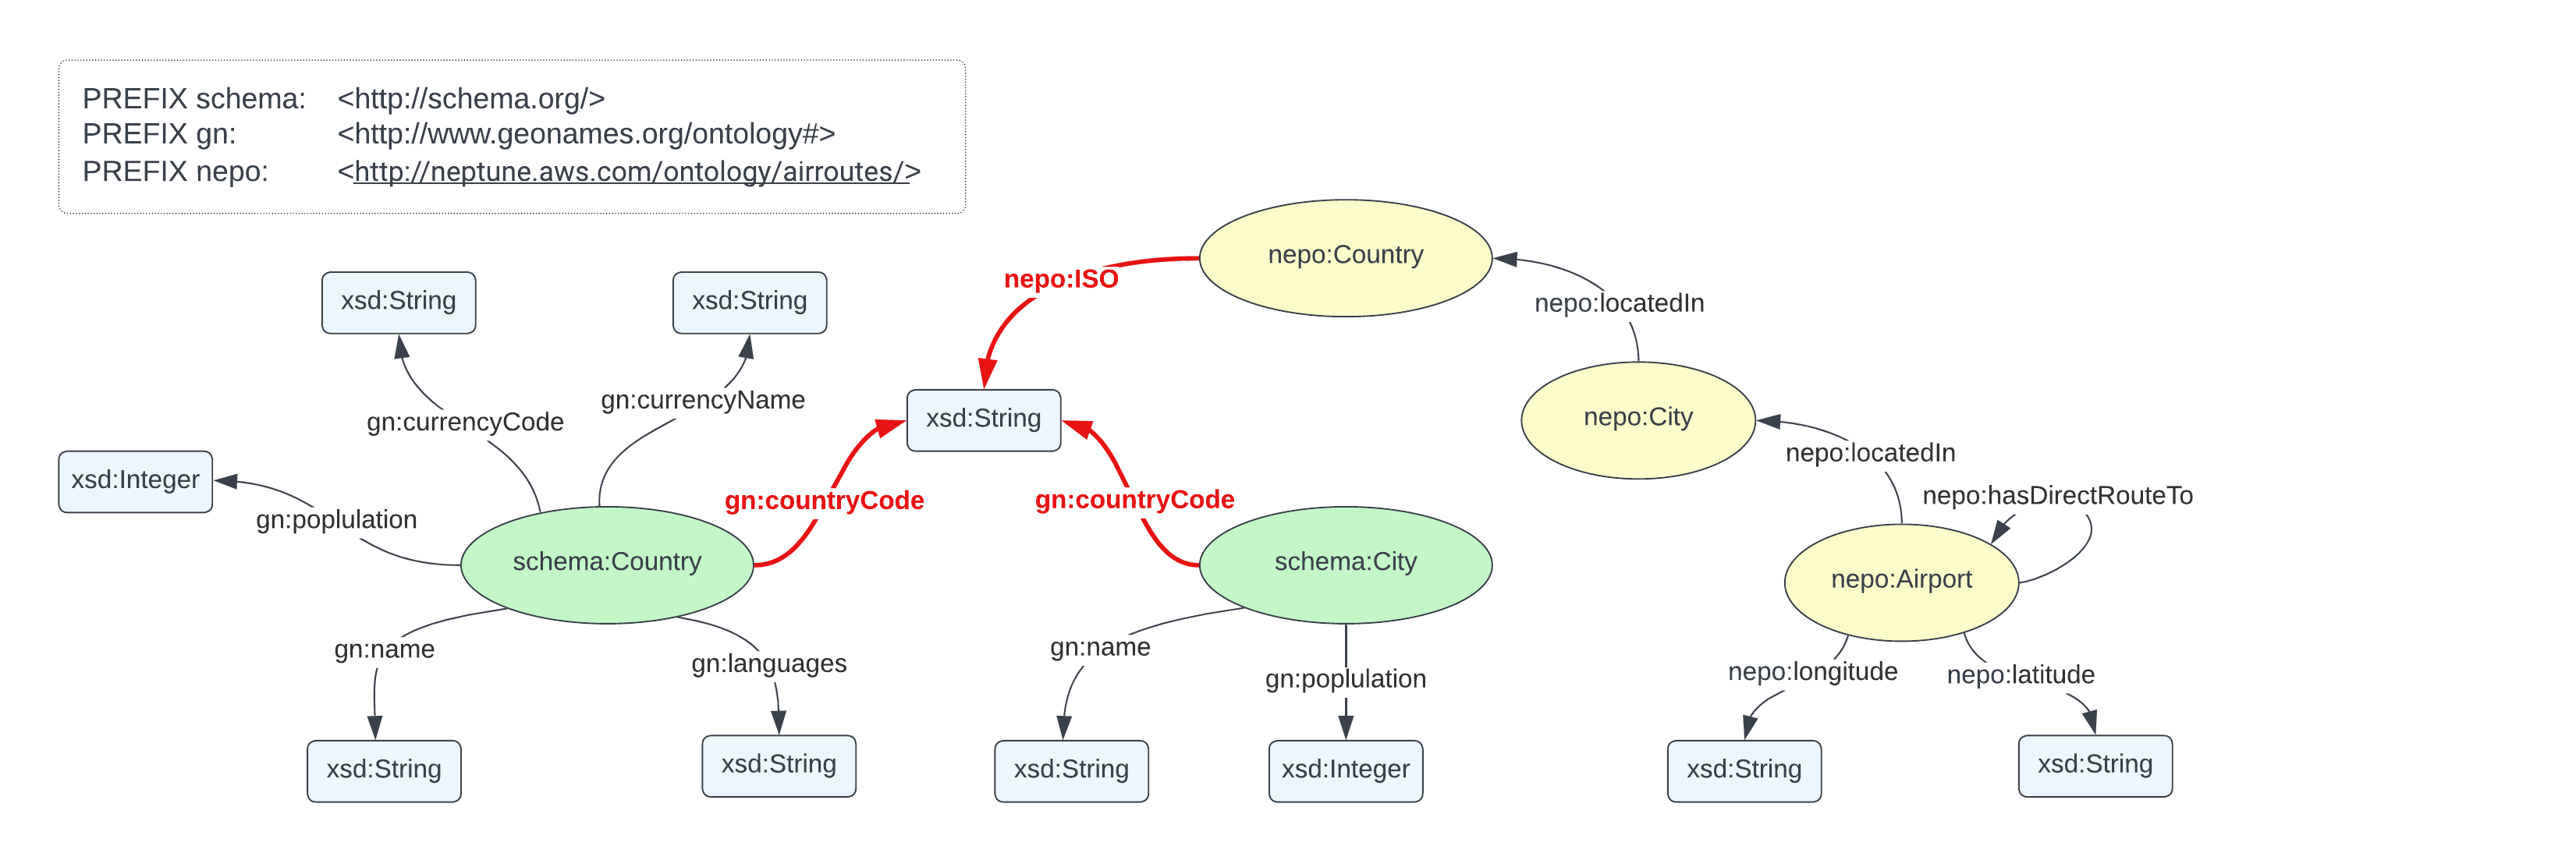

## Loading the GeoNames RDF graph

Execute the cell below to load the GeoNames cities and countries RDF graph, using [Neptune batch load](https://docs.aws.amazon.com/neptune-analytics/latest/userguide/batch-load.html).  

In [ ]:
%%oc

CALL neptune.load(
  {
    source: "s3://aws-neptune-customer-samples/geonames-rdf/geonames-cities-countries.nt",
    region: "us-east-1",
    format: "ntriples",
    failOnError: true,
    blankNodeHandling: "convertToIri"
  }
)

## Loading the Air Routes RDF graph

Run the following to load the AirRoutes RDF graph, using [Neptune batch load](https://docs.aws.amazon.com/neptune-analytics/latest/userguide/batch-load.html).  

In [ ]:
%%oc

CALL neptune.load(
  {
    source: "s3://aws-neptune-customer-samples/airroutes-rdf/airroutes.nt",
    region: "us-east-1",
    format: "ntriples",
    failOnError: true,
    blankNodeHandling: "convertToIri"
  }
)

## Checking the contents of the graph

Now that we have both RDF graphs loaded, run the following cell to see a list of labels/RDF-classes and the number of instances for each label/RDF-class in the dataset. You should see labels/classes from both GeoNames and Air Routes. 

In [ ]:
%%oc

MATCH (n)
WITH labels(n) AS lbls
UNWIND lbls AS lbl
RETURN lbl AS Label, COUNT(*) AS Count
ORDER BY Count DESC;

## Linked data queries

RDF practitioners often use publicly available data to enrich their own data and provide better solutions for their consumers. 

In this notebook, the Air Routes graph is our internal data, and the GeoNames is the public RDF dataset used to enrich the solution. 

There are many ways to join the two datasets, as GeoNames has a wide range of internationally recognised identifiers that follow various standards. We have chosen to link the to graphs by the [ISO country codes](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes) for simplicity. 

### Finding GeoNames countries

Run the following cell to list all the GeoNames countries.

In [ ]:
%%oc
PREFIX gn: <http://www.geonames.org/ontology#>
PREFIX schema: <http://schema.org/>

MATCH (country:schema::Country)
RETURN country.gn::name, country.gn::countryCode
ORDER BY country.gn::name

### Finding Air Routes countries

Run the following cell to list all the Air Routes countries.

In [ ]:
%%oc
PREFIX nepo: <http://neptune.aws.com/ontology/airroutes/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

MATCH (country:nepo::Country)
RETURN country.rdfs::label, country.nepo::ISO
ORDER BY country.rdfs::label

### Finding countries from both graphs by country code

Run the following cell to list all the countries from both graphs where the ISO country code matches. 

In [ ]:
%%oc
PREFIX nepo: <http://neptune.aws.com/ontology/airroutes/>
PREFIX nepr: <http://neptune.aws.com/ontology/airroutes/resource#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX gn: <http://www.geonames.org/ontology#>
PREFIX schema: <http://schema.org/>

MATCH (gn_country:schema::Country), (ar_country:nepo::Country)
WHERE gn_country.gn::countryCode = ar_country.nepo::ISO
RETURN gn_country.gn::name, ar_country.rdfs::label

### Linking countries with `skos:exactMatch`

The query below creates an edge between the Air Routes countries and the GeoNames countries where the ISO country codes match, using the W3C recommended predicate [`skos:exactMatch`](https://www.w3.org/TR/skos-reference/#exactMatch).

Select the graph tab to see the new relationship in a network diagram.

In [ ]:
%%oc -d <http://www.w3.org/2000/01/rdf-schema#label>

PREFIX nepo: <http://neptune.aws.com/ontology/airroutes/>
PREFIX gn: <http://www.geonames.org/ontology#>
PREFIX schema: <http://schema.org/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

MATCH (gn_country:schema::Country), (ar_country:nepo::Country)
WHERE gn_country.gn::countryCode = ar_country.nepo::ISO
CREATE (gn_country)-[matches :skos::exactMatch]->(ar_country)
RETURN gn_country, matches, ar_country

### Checking the language and currency at destination of flight

Now that the graphs are linked, we can query both graphs as one.

For a flight between London and Madrid (Air Routes), the query below find the currency needed as well as the languages spoken at the destination, Madrid (GeoNames).

In [ ]:
%%oc

PREFIX nepo: <http://neptune.aws.com/ontology/airroutes/>
PREFIX gn: <http://www.geonames.org/ontology#>
PREFIX schema: <http://schema.org/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

MATCH (origin:nepo::Airport)-[p:nepo::hasDirectRouteTo]->(destination:nepo::Airport)
        -[:nepo::locatedIn*..2]-(ar_country:nepo::Country)
        -[:skos::exactMatch]-(geo_country:schema::Country)
        
WHERE origin.nepo::IATA = "LHR" AND destination.nepo::IATA = "MAD"  
RETURN DISTINCT destination.rdfs::label, geo_country.gn::currencyCode, geo_country.gn::languages